In [1]:
import numpy as np
import pandas as pd
import json
import csv

import tensorflow as tf
import keras.backend as K

from os import listdir, rename, makedirs
from os.path import isfile, join, exists
from shutil import copyfile

from keras.applications import densenet, xception
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from keras.optimizers import SGD, Adam
from keras.layers import Dropout, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import utils
from keras.preprocessing import image

from matplotlib import pyplot as plt

from demo_utils import plot_history, plot_lr
from model_utils import get_checkpoint
from clr import CyclicLR

%matplotlib inline

np.random.seed(42)
tf.set_random_seed(42)

This setting allows Tensorflow to allocate GPU memory in runtime rather than at the session initialization. Remove this cell if you don't have GPU.

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Generate bottleneck features

In [3]:
train_data_dir = 'train'
val_data_dir = 'validation'
test_data_dir = 'test'

img_height = 299
img_width = 299

nb_train_samples, nb_validation_samples, nb_test_samples = (37184, 12800, 25600)

batch_size = 16

### Load base model and generate bottleneck features

Image from: http://www.mdpi.com/2072-4292/9/5/498/htm
![title](images/bottleneck.png)

In [ ]:
base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

validation_generator = data_generator.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Next cell requires some time to run. **You should skip it** and just load bottleneck features.

In [4]:
bottleneck_features_train = base_model.predict_generator(
        train_generator,
        nb_train_samples // batch_size,
        verbose=1)

np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size,
        verbose=1)

np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

Found 37184 images belonging to 128 classes.
2324/2324 [==============================] - 258s 111ms/step
Found 12800 images belonging to 128 classes.
800/800 [==============================] - 88s 110ms/step


**Load bottleneck features:**

In [23]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = utils.to_categorical(train_generator.classes)[:nb_train_samples]

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = utils.to_categorical(validation_generator.classes)[:nb_validation_samples]

# Train last layers on the bottleneck features

If you want to speed up next cell, decrease number of epochs to 20-30.

In [32]:
batch_size = 256
epochs = 50

base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

model = Sequential()
model.add(Dense(128, activation='softmax', name='top_softmax', input_shape=base_model.output_shape[1:]))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=get_checkpoint('top-weights-xception'), verbose=1, save_best_only=True)

history_1 = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 37184 samples, validate on 12800 samples
Epoch 1/50
37184/37184 [==============================] - 7s 200us/step - loss: 4.7947 - acc: 0.0238 - val_loss: 4.7128 - val_acc: 0.0459

Epoch 00001: val_loss improved from inf to 4.71278, saving model to top-weights-xception.hdf5
Epoch 2/50
37184/37184 [==============================] - 1s 35us/step - loss: 4.6121 - acc: 0.0909 - val_loss: 4.5444 - val_acc: 0.1330

Epoch 00002: val_loss improved from 4.71278 to 4.54441, saving model to top-weights-xception.hdf5
Epoch 3/50
37184/37184 [==============================] - 1s 34us/step - loss: 4.4383 - acc: 0.1908 - val_loss: 4.3830 - val_acc: 0.2223

Epoch 00003: val_loss improved from 4.54441 to 4.38296, saving model to top-weights-xception.hdf5
Epoch 4/50
37184/37184 [==============================] - 1s 35us/step - loss: 4.2720 - acc: 0.2733 - val_loss: 4.2279 - val_acc: 0.2904

Epoch 00004: val_loss improved from 4.38296 to 4.22791, saving model to top-weights-xception.hdf5
Epoch 5/5


Epoch 00035: val_loss improved from 2.08500 to 2.06002, saving model to top-weights-xception.hdf5
Epoch 36/50
37184/37184 [==============================] - 1s 35us/step - loss: 1.9412 - acc: 0.6138 - val_loss: 2.0363 - val_acc: 0.5845

Epoch 00036: val_loss improved from 2.06002 to 2.03626, saving model to top-weights-xception.hdf5
Epoch 37/50
37184/37184 [==============================] - 1s 35us/step - loss: 1.9173 - acc: 0.6159 - val_loss: 2.0136 - val_acc: 0.5863

Epoch 00037: val_loss improved from 2.03626 to 2.01359, saving model to top-weights-xception.hdf5
Epoch 38/50
37184/37184 [==============================] - 1s 35us/step - loss: 1.8946 - acc: 0.6178 - val_loss: 1.9920 - val_acc: 0.5879

Epoch 00038: val_loss improved from 2.01359 to 1.99196, saving model to top-weights-xception.hdf5
Epoch 39/50
37184/37184 [==============================] - 1s 35us/step - loss: 1.8729 - acc: 0.6195 - val_loss: 1.9713 - val_acc: 0.5896

Epoch 00039: val_loss improved from 1.99196 to 1.97

Best accuracy: 0.601640625
Best logloss: 1.792749423980713


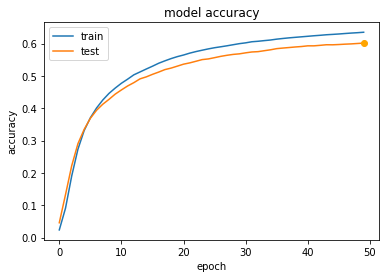

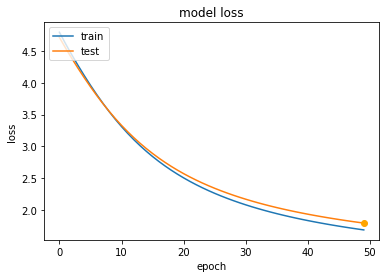

In [33]:
plot_history(history_1)

In [34]:
batch_size = 256
epochs = 50

base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

model = Sequential()
model.add(Dense(128, activation='softmax', name='top_softmax', input_shape=base_model.output_shape[1:]))

model.compile(optimizer=SGD(lr=0.05),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=get_checkpoint('top-weights-xception'), verbose=1, save_best_only=True)

history_2 = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 37184 samples, validate on 12800 samples
Epoch 1/50
37184/37184 [==============================] - 8s 222us/step - loss: 4.4671 - acc: 0.1748 - val_loss: 4.0891 - val_acc: 0.3348

Epoch 00001: val_loss improved from inf to 4.08910, saving model to top-weights-xception.hdf5
Epoch 2/50
37184/37184 [==============================] - 2s 42us/step - loss: 3.7006 - acc: 0.4210 - val_loss: 3.4449 - val_acc: 0.4399

Epoch 00002: val_loss improved from 4.08910 to 3.44489, saving model to top-weights-xception.hdf5
Epoch 3/50
37184/37184 [==============================] - 2s 43us/step - loss: 3.1210 - acc: 0.4982 - val_loss: 2.9713 - val_acc: 0.4915

Epoch 00003: val_loss improved from 3.44489 to 2.97131, saving model to top-weights-xception.hdf5
Epoch 4/50
37184/37184 [==============================] - 2s 43us/step - loss: 2.7048 - acc: 0.5441 - val_loss: 2.6314 - val_acc: 0.5298

Epoch 00004: val_loss improved from 2.97131 to 2.63137, saving model to top-weights-xception.hdf5
Epoch 5/5


Epoch 00035: val_loss improved from 1.27947 to 1.27169, saving model to top-weights-xception.hdf5
Epoch 36/50
37184/37184 [==============================] - 2s 42us/step - loss: 1.1076 - acc: 0.7108 - val_loss: 1.2646 - val_acc: 0.6571

Epoch 00036: val_loss improved from 1.27169 to 1.26462, saving model to top-weights-xception.hdf5
Epoch 37/50
37184/37184 [==============================] - 2s 43us/step - loss: 1.0989 - acc: 0.7125 - val_loss: 1.2576 - val_acc: 0.6585

Epoch 00037: val_loss improved from 1.26462 to 1.25756, saving model to top-weights-xception.hdf5
Epoch 38/50
37184/37184 [==============================] - 2s 42us/step - loss: 1.0904 - acc: 0.7149 - val_loss: 1.2505 - val_acc: 0.6601

Epoch 00038: val_loss improved from 1.25756 to 1.25052, saving model to top-weights-xception.hdf5
Epoch 39/50
37184/37184 [==============================] - 2s 42us/step - loss: 1.0823 - acc: 0.7167 - val_loss: 1.2446 - val_acc: 0.6611

Epoch 00039: val_loss improved from 1.25052 to 1.24

Best accuracy: 0.66953125
Best logloss: 1.189909987449646


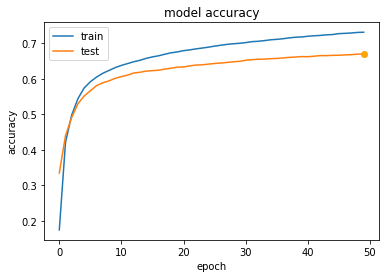

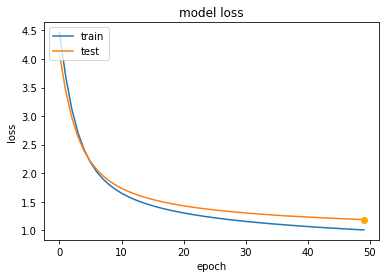

In [35]:
plot_history(history_2)

In [38]:
batch_size = 256
epochs = 50

base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

model = Sequential()
model.add(Dropout(0.2, name='top_dropout', input_shape=base_model.output_shape[1:]))
model.add(Dense(128, activation='softmax', name='top_softmax'))

model.compile(optimizer=SGD(lr=0.05),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=get_checkpoint('top-weights-xception'), verbose=1, save_best_only=True)

history_3 = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 37184 samples, validate on 12800 samples
Epoch 1/50
37184/37184 [==============================] - 10s 268us/step - loss: 4.4670 - acc: 0.1565 - val_loss: 4.0783 - val_acc: 0.3355

Epoch 00001: val_loss improved from inf to 4.07828, saving model to top-weights-xception.hdf5
Epoch 2/50
37184/37184 [==============================] - 1s 40us/step - loss: 3.7033 - acc: 0.3933 - val_loss: 3.4379 - val_acc: 0.4390

Epoch 00002: val_loss improved from 4.07828 to 3.43787, saving model to top-weights-xception.hdf5
Epoch 3/50
37184/37184 [==============================] - 1s 40us/step - loss: 3.1271 - acc: 0.4748 - val_loss: 2.9672 - val_acc: 0.4916

Epoch 00003: val_loss improved from 3.43787 to 2.96723, saving model to top-weights-xception.hdf5
Epoch 4/50
37184/37184 [==============================] - 1s 40us/step - loss: 2.7166 - acc: 0.5241 - val_loss: 2.6317 - val_acc: 0.5256

Epoch 00004: val_loss improved from 2.96723 to 2.63167, saving model to top-weights-xception.hdf5
Epoch 5/


Epoch 00035: val_loss improved from 1.28047 to 1.27268, saving model to top-weights-xception.hdf5
Epoch 36/50
37184/37184 [==============================] - 1s 40us/step - loss: 1.1340 - acc: 0.7011 - val_loss: 1.2653 - val_acc: 0.6581

Epoch 00036: val_loss improved from 1.27268 to 1.26529, saving model to top-weights-xception.hdf5
Epoch 37/50
37184/37184 [==============================] - 1s 40us/step - loss: 1.1254 - acc: 0.7016 - val_loss: 1.2588 - val_acc: 0.6590

Epoch 00037: val_loss improved from 1.26529 to 1.25882, saving model to top-weights-xception.hdf5
Epoch 38/50
37184/37184 [==============================] - 1s 40us/step - loss: 1.1161 - acc: 0.7043 - val_loss: 1.2523 - val_acc: 0.6591

Epoch 00038: val_loss improved from 1.25882 to 1.25234, saving model to top-weights-xception.hdf5
Epoch 39/50
37184/37184 [==============================] - 1s 40us/step - loss: 1.1101 - acc: 0.7039 - val_loss: 1.2459 - val_acc: 0.6594

Epoch 00039: val_loss improved from 1.25234 to 1.24

Best accuracy: 0.66984375
Best logloss: 1.1905516815185546


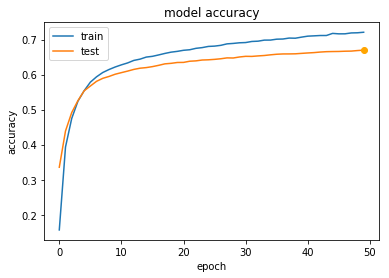

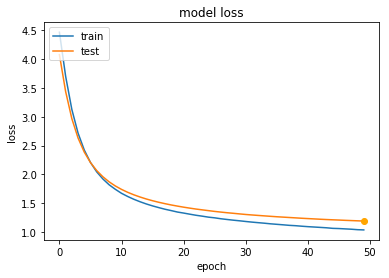

In [39]:
plot_history(history_3)

# Add augmentation

If you want to speed up next cell, decrease number of steps_per_epoch by ~10 times

If you want to skip several cells and load pre-trained weights, you can always use:

```python
model.load_weights(get_checkpoint('top-weights-xception'))
```

In [49]:
batch_size = 16
epochs = 1

base_model = xception.Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_width, img_height, 3),
                            pooling='avg')

for layer in base_model.layers[:-7]:
    layer.trainable = False

top_model = Sequential()    
top_model.add(Dropout(0.3, name='top_dropout', input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='softmax', name='top_softmax'))
top_model.load_weights(get_checkpoint('top-weights-xception'), by_name=True)

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=get_checkpoint('weights-xception'), verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        preprocessing_function=xception.preprocess_input,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

history_4 = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            callbacks=[checkpointer],
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 37184 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Epoch 1/1
2324/2324 [==============================] - 886s 381ms/step - loss: 1.5217 - acc: 0.5960 - val_loss: 1.1724 - val_acc: 0.6626

Epoch 00001: val_loss improved from inf to 1.17237, saving model to weights-xception.hdf5


In [32]:
batch_size = 16
epochs = 1

base_model = xception.Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_width, img_height, 3),
                            pooling='avg')

for layer in base_model.layers[:-27]:
    layer.trainable = False

top_model = Sequential()    
top_model.add(Dropout(0.3, name='top_dropout', input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='softmax', name='top_softmax'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.load_weights(get_checkpoint('weights-xception'))

model.compile(optimizer=SGD(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=get_checkpoint('weights-xception-1'), verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        preprocessing_function=xception.preprocess_input,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

history_4 = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            callbacks=[checkpointer],
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 37184 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Epoch 1/1
2324/2324 [==============================] - 788s 339ms/step - loss: 1.4438 - acc: 0.6136 - val_loss: 1.2006 - val_acc: 0.6555

Epoch 00001: val_loss improved from inf to 1.20061, saving model to weights-xception-1.hdf5


In [33]:
batch_size = 16
epochs = 1

base_model = xception.Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_width, img_height, 3),
                            pooling='avg')

for layer in base_model.layers:
    layer.trainable = True

top_model = Sequential()    
top_model.add(Dropout(0.3, name='top_dropout', input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='softmax', name='top_softmax'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.load_weights(get_checkpoint('weights-xception-1'))

model.compile(optimizer=SGD(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=get_checkpoint('weights-xception-2'), verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        preprocessing_function=xception.preprocess_input,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

history_4 = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            callbacks=[checkpointer],
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 37184 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Epoch 1/1
2324/2324 [==============================] - 1224s 526ms/step - loss: 1.4265 - acc: 0.6160 - val_loss: 1.3274 - val_acc: 0.6358

Epoch 00001: val_loss improved from inf to 1.32735, saving model to weights-xception-2.hdf5


# Cyclic learning rate

Cyclic learning rate for Keras - https://github.com/bckenstler/CLR

In [29]:
start_lr = 1e-6
end_lr = 1
batch_size = 16
epochs = 2
steps_per_epoch = nb_train_samples // batch_size

base_model = xception.Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_width, img_height, 3),
                            pooling='avg')

for layer in base_model.layers:
    layer.trainable = True

top_model = Sequential()    
top_model.add(Dropout(0.3, name='top_dropout', input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='softmax', name='top_softmax'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.load_weights(get_checkpoint('weights-xception'))

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

lr_space = np.logspace(np.log10(start_lr), np.log10(end_lr), steps_per_epoch*epochs)

def scale_fn(iteration):
    return lr_space[int(iteration) - 1]

clr = CyclicLR(base_lr=start_lr, max_lr=end_lr, step_size=epochs*steps_per_epoch, scale_mode='iterations', scale_fn=scale_fn)

history_4 = model.fit_generator(train_generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs,
                            callbacks=[clr])

Found 37184 images belonging to 128 classes.
Epoch 1/2
2324/2324 [==============================] - 1201s 517ms/step - loss: 1.4318 - acc: 0.6188
Epoch 2/2
2324/2324 [==============================] - 1194s 514ms/step - loss: 1.3993 - acc: 0.6131


Best loss: 0.4149343967437744 (at 0.054779913276433945)


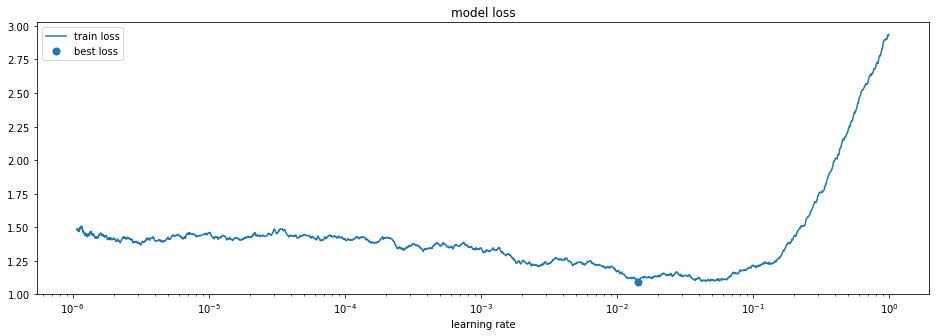

In [66]:
plot_lr(clr.history, 100)

# Training whole network

In [4]:
import cv2

from albumentations import Compose, OneOf, HorizontalFlip, RandomBrightness, RandomContrast, ShiftScaleRotate, HueSaturationValue
from albumentations import MotionBlur, MedianBlur, Blur

from demo_utils import show_augmentation

Augmentations library - https://github.com/albu/albumentations

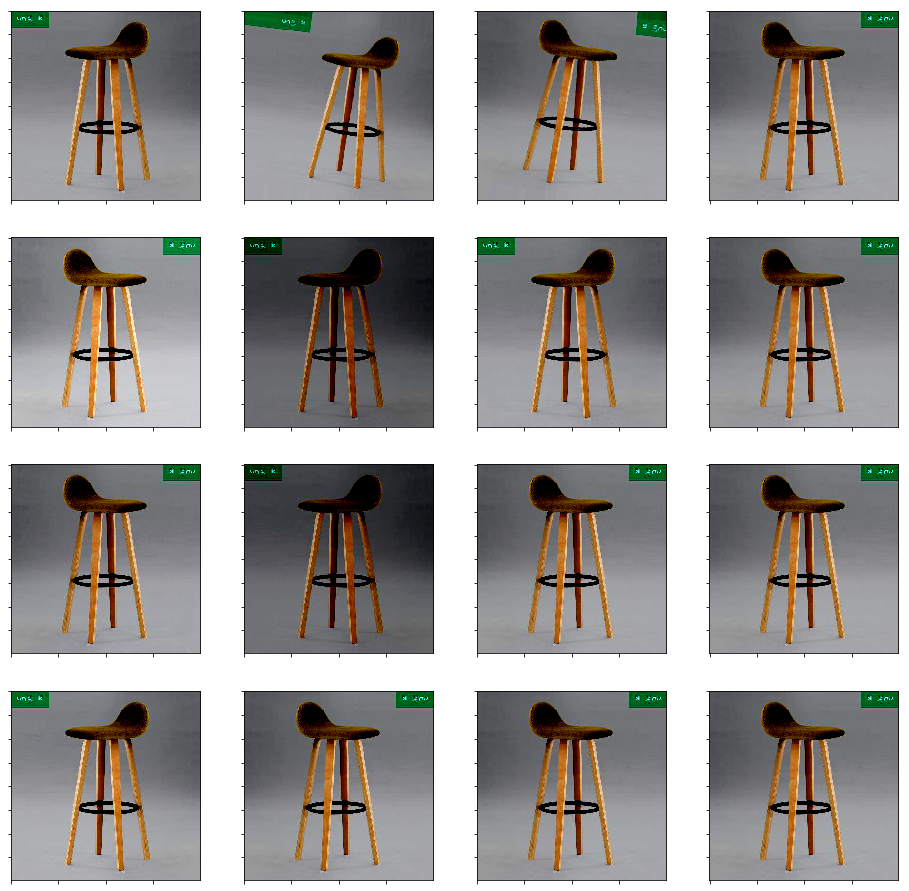

In [5]:
def preprocess_input_soft(image):    
    augmentation = Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.10, scale_limit=0.10, rotate_limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.25),
        OneOf([
            RandomBrightness(p=0.33, limit=0.1),
            RandomContrast(p=0.33, limit=0.1), 
            HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.33),
        ], p=0.25),
    ], p=1.0)
    
    image_data = {'image': np.uint8(image)}
    aug_image = augmentation(**image_data)['image']
    
    return xception.preprocess_input(aug_image)

images = show_augmentation(preprocess_input_soft)

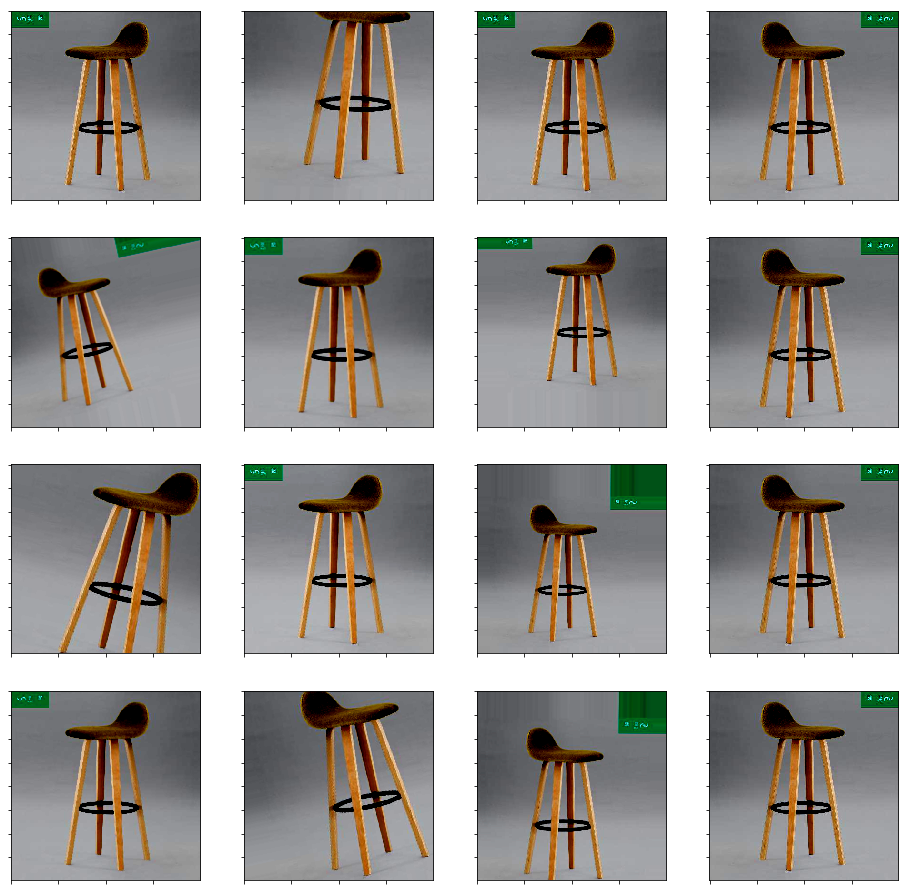

In [6]:
def preprocess_input_hard(image):    
    augmentation = Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.15, scale_limit=0.3, rotate_limit=15, border_mode=cv2.BORDER_REPLICATE, p=0.3),
        OneOf([
            RandomBrightness(p=0.33, limit=0.15),
            RandomContrast(p=0.33, limit=0.15),
            HueSaturationValue(hue_shift_limit=0.15, sat_shift_limit=0.15, val_shift_limit=0.15, p=0.33)
        ], p=0.3),
        OneOf([
            MotionBlur(p=0.33, blur_limit=4),
            MedianBlur(p=0.33, blur_limit=4),
            Blur(p=0.33, blur_limit=4)
        ], p=0.25),
    ], p=1.0)
    
    image_data = {'image': np.uint8(image)}
    aug_image = augmentation(**image_data)['image']
    
    return xception.preprocess_input(aug_image)

images = show_augmentation(preprocess_input_hard)

In [40]:
start_lr = 1e-5
end_lr = 5e-3
batch_size = 16
epochs = 20
steps_per_epoch = nb_train_samples // batch_size

base_model = xception.Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_width, img_height, 3),
                            pooling='avg')

for layer in base_model.layers:
    layer.trainable = True

top_model = Sequential()    
top_model.add(Dropout(0.3, name='top_dropout', input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='softmax', name='top_softmax'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.load_weights(get_checkpoint('weights-xception-2'))

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input_hard) # Augmentation
test_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input) # No augmentation

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

clr = CyclicLR(base_lr=start_lr,
               max_lr=end_lr,
               step_size=2*steps_per_epoch, # Length of slope (full cycle is two times longer)
               scale_mode='triangular2')

checkpointer = ModelCheckpoint(filepath=get_checkpoint('weights-xception-3'), verbose=1, monitor='val_acc', save_best_only=True)

history_4 = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            callbacks=[checkpointer, clr],
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 37184 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Epoch 1/20
2324/2324 [==============================] - 1278s 550ms/step - loss: 1.2917 - acc: 0.6444 - val_loss: 1.0681 - val_acc: 0.6862

Epoch 00001: val_acc improved from -inf to 0.68617, saving model to weights-xception-3.hdf5
Epoch 2/20
2324/2324 [==============================] - 1267s 545ms/step - loss: 1.0246 - acc: 0.7047 - val_loss: 0.9355 - val_acc: 0.7225

Epoch 00002: val_acc improved from 0.68617 to 0.72250, saving model to weights-xception-3.hdf5
Epoch 3/20
2324/2324 [==============================] - 1270s 547ms/step - loss: 0.8549 - acc: 0.7491 - val_loss: 0.8691 - val_acc: 0.7400

Epoch 00003: val_acc improved from 0.72250 to 0.74000, saving model to weights-xception-3.hdf5
Epoch 4/20
2324/2324 [==============================] - 1266s 545ms/step - loss: 0.7589 - acc: 0.7773 - val_loss: 0.8535 - val_acc: 0.7460

Epoch 00004: val_acc improved from 0.74000 to 0.74602, saving model 

Best accuracy: 0.782890625
Best logloss: 0.7474553857810678


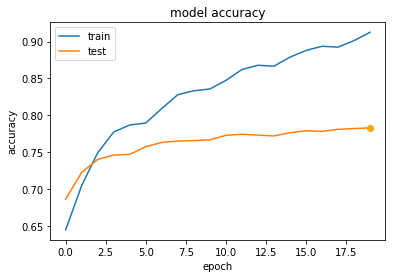

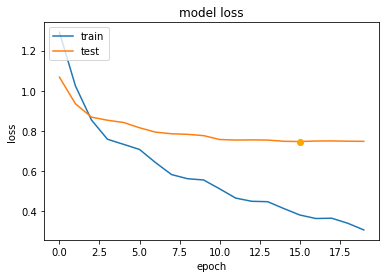

In [41]:
plot_history(history_4)

# Weighted loss

In [9]:
from sklearn.utils.class_weight import compute_class_weight

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input_hard)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# Class weights
train_labels = utils.to_categorical(train_generator.classes)
y_integers = np.argmax(train_labels, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights_dict = dict(enumerate(class_weights))

Found 37184 images belonging to 128 classes.


In [10]:
start_lr = 1e-5
end_lr = 5e-3
batch_size = 16
epochs = 20
steps_per_epoch = nb_train_samples // batch_size

base_model = xception.Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_width, img_height, 3),
                            pooling='avg')

for layer in base_model.layers:
    layer.trainable = True

top_model = Sequential()    
top_model.add(Dropout(0.3, name='top_dropout', input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='softmax', name='top_softmax'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.load_weights(get_checkpoint('weights-xception-2'))

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input_hard)
test_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

clr = CyclicLR(base_lr=start_lr,
               max_lr=end_lr,
               step_size=2*steps_per_epoch,
               scale_mode='triangular2')

checkpointer = ModelCheckpoint(filepath=get_checkpoint('weights-xception-4'), verbose=1, monitor='val_acc', save_best_only=True)

history_4 = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            class_weight=class_weights_dict,
                            callbacks=[checkpointer, clr],
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 37184 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Epoch 1/20
2324/2324 [==============================] - 1208s 520ms/step - loss: 1.3242 - acc: 0.6442 - val_loss: 1.0518 - val_acc: 0.6895

Epoch 00001: val_acc improved from -inf to 0.68945, saving model to weights-xception-4.hdf5
Epoch 2/20
2324/2324 [==============================] - 1244s 535ms/step - loss: 1.0389 - acc: 0.7044 - val_loss: 0.9230 - val_acc: 0.7230

Epoch 00002: val_acc improved from 0.68945 to 0.72297, saving model to weights-xception-4.hdf5
Epoch 3/20
2324/2324 [==============================] - 1241s 534ms/step - loss: 0.8728 - acc: 0.7464 - val_loss: 0.8565 - val_acc: 0.7433

Epoch 00003: val_acc improved from 0.72297 to 0.74328, saving model to weights-xception-4.hdf5
Epoch 4/20
2324/2324 [==============================] - 1246s 536ms/step - loss: 0.7721 - acc: 0.7734 - val_loss: 0.8384 - val_acc: 0.7491

Epoch 00004: val_acc improved from 0.74328 to 0.74906, saving model 

Best accuracy: 0.787734375
Best logloss: 0.7334844713238999


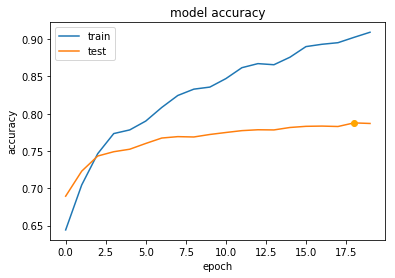

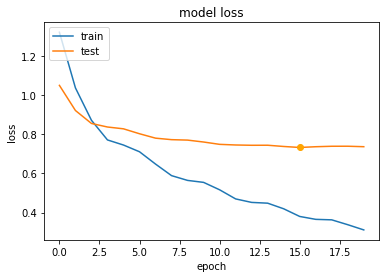

In [11]:
plot_history(history_4)

In [13]:
start_lr = 1e-5
end_lr = 5e-3
batch_size = 16
epochs = 100
steps_per_epoch = nb_train_samples // batch_size

base_model = xception.Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_width, img_height, 3),
                            pooling='avg')

for layer in base_model.layers:
    layer.trainable = True

top_model = Sequential()    
top_model.add(Dropout(0.4, name='top_dropout', input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='softmax', name='top_softmax'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.load_weights(get_checkpoint('weights-xception-2'))

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input_hard)
test_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

clr = CyclicLR(base_lr=start_lr,
               max_lr=end_lr,
               step_size=2*steps_per_epoch,
               scale_mode='triangular2')

checkpointer = ModelCheckpoint(filepath=get_checkpoint('weights-xception-5'), verbose=1, monitor='val_acc', save_best_only=True)
early_stopping = EarlyStopping(patience=5, verbose=1, monitor='val_acc', mode='max')

history_5 = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            class_weight=class_weights_dict,
                            callbacks=[checkpointer, early_stopping, clr],
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 37184 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Epoch 1/100
2324/2324 [==============================] - 1300s 559ms/step - loss: 1.3455 - acc: 0.6392 - val_loss: 1.0528 - val_acc: 0.6894

Epoch 00001: val_acc improved from -inf to 0.68937, saving model to weights-xception-5.hdf5
Epoch 2/100
2324/2324 [==============================] - 1207s 519ms/step - loss: 1.0531 - acc: 0.6968 - val_loss: 0.9143 - val_acc: 0.7283

Epoch 00002: val_acc improved from 0.68937 to 0.72828, saving model to weights-xception-5.hdf5
Epoch 3/100
2324/2324 [==============================] - 1214s 522ms/step - loss: 0.8869 - acc: 0.7422 - val_loss: 0.8558 - val_acc: 0.7436

Epoch 00003: val_acc improved from 0.72828 to 0.74359, saving model to weights-xception-5.hdf5
Epoch 4/100
2324/2324 [==============================] - 1212s 522ms/step - loss: 0.7807 - acc: 0.7715 - val_loss: 0.8363 - val_acc: 0.7503

Epoch 00004: val_acc improved from 0.74359 to 0.75031, saving mo

Best accuracy: 0.790703125
Best logloss: 0.737932166387909


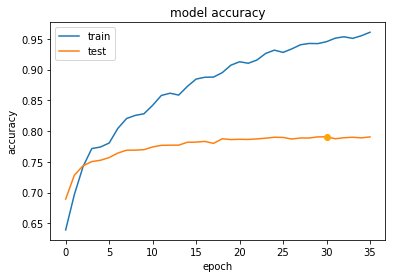

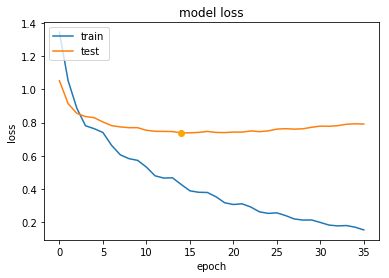

In [44]:
plot_history(history_5)

# Evaluation and TTA

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
model.load_weights(get_checkpoint('weights-xception-5'))

In [37]:
tta_level = 9

In [38]:
test_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)

validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

probs = []
probs.append(model.predict_generator(validation_generator))

for i in range(tta_level):
    test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input_soft)

    validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    
    probs.append(model.predict_generator(validation_generator))

Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.
Found 12800 images belonging to 128 classes.


In [39]:
results = pd.DataFrame(columns=['id', 'predicted', 'predicted_tta', 'actual'])

predictions = np.argmax(probs[0], axis=1) + 1
predictions_tta = np.argmax(np.mean(probs, axis=0), axis=1) + 1

for i, file in enumerate(validation_generator.filenames):
    id = file.split('_')[0].split('/')[1]
    predicted = predictions[i]
    predicted_tta = predictions_tta[i]
    results.loc[i] = [id, predicted, predicted_tta, validation_generator.classes[i] + 1]
    
results['actual'] = results['actual'].astype(np.int32)
results['predicted'] = results['predicted'].astype(np.int32)
results['predicted_tta'] = results['predicted_tta'].astype(np.int32)
    
results.head()

,id,predicted,predicted_tta,actual
0,2308,1,1,1
1,3990,1,1,1
2,4122,114,114,1
3,89810,125,125,1
4,89839,1,1,1


Accuracy may slightly differ from validation during training due to https://github.com/keras-team/keras/issues/6499

In [40]:
accuracy = accuracy_score(results['actual'], results['predicted'])
accuracy_tta = accuracy_score(results['actual'], results['predicted_tta'])

print(f'Accuracy: {accuracy}. Accuracy with TTA: {accuracy_tta}')

Accuracy: 0.790703125. Accuracy with TTA: 0.7928125


In [41]:
test_datagen = image.ImageDataGenerator(preprocessing_function=xception.preprocess_input)

validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

probs = []
probs.append(model.predict_generator(validation_generator))

for i in range(tta_level):
    test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input_soft)

    validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    
    probs.append(model.predict_generator(validation_generator))

Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.
Found 25600 images belonging to 128 classes.


In [42]:
results = pd.DataFrame(columns=['id', 'predicted', 'predicted_tta', 'actual'])

predictions = np.argmax(probs[0], axis=1) + 1
predictions_tta = np.argmax(np.mean(probs, axis=0), axis=1) + 1

for i, file in enumerate(validation_generator.filenames):
    id = file.split('.')[0].split('/')[1]
    predicted = predictions[i]
    predicted_tta = predictions_tta[i]
    results.loc[i] = [id, predicted, predicted_tta, validation_generator.classes[i] + 1]
    
results['actual'] = results['actual'].astype(np.int32)
results['predicted'] = results['predicted'].astype(np.int32)
results['predicted_tta'] = results['predicted_tta'].astype(np.int32)
    
results.head()

,id,predicted,predicted_tta,actual
0,2593,1,1,1
1,3758,38,38,1
2,426,85,85,1
3,4465,1,1,1
4,6315,1,85,1


In [43]:
accuracy = accuracy_score(results['actual'], results['predicted'])
accuracy_tta = accuracy_score(results['actual'], results['predicted_tta'])

print(f'Accuracy: {accuracy}. Accuracy with TTA: {accuracy_tta}')

Accuracy: 0.7952734375. Accuracy with TTA: 0.80015625


In [45]:
# Save test predictions to use later.
results.set_index('id').to_csv('test_predictions.csv')